In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import lalsimulation as lalsim

from pycbc.filter.matchedfilter import match
from pycbc.types import FrequencySeries

from bilby_lisa.source import lisa_binary_black_hole
from bilby_lisa.source_LW import lisa_binary_black_hole_LW
from bilby_lisa.source_TD import lisa_binary_black_hole_TD

from lisatools.sensitivity import get_sensitivity
from bbhx.utils.transform import LISA_to_SSB

import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font_scale=1.5,
)

In [31]:
Mtot = 2e7
q = 2
m1 = q / (1 + q) * Mtot
m2 = 1 / (1 + q) * Mtot
s1x = 0.0
s1y = 0.0
s1z = 0.5
s2x = 0.0
s2y = 0.0
s2z = 0.4
phiRef = 0.0
distance = 18 * 1e3
inclination = np.pi / 3

f_max = 1e-2 / (Mtot/2e7)
f_ref = 1e-4 / (Mtot/2e7)
f_min = 1e-4 / (Mtot/2e7)
deltaF = 1/2628000.0 # 1 month duration

frequency_array = np.arange(f_min, f_max, deltaF)

ra = np.pi / 3
dec = np.pi / 3
psi = np.pi / 3

geocent_time = 0.0

In [32]:
dict_bbhx = lisa_binary_black_hole(
    frequency_array, m1, m2, distance, s1z, s2z,
    inclination, phiRef, ra, dec, psi, geocent_time,
    reference_frequency=f_ref, minimum_frequency=f_min
)

In [33]:
(theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2) = (
    lalsim.SimInspiralTransformPrecessingWvf2PE(
        inclination, s1x, s1y, s1z, s2x, s2y, s2z, m1, m2, f_ref, phiRef
    )
)

In [34]:
dict_lw = lisa_binary_black_hole_LW(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

In [35]:
dict_td = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

In [44]:
LISA_to_SSB(0.0, np.pi/3, np.pi/3, np.pi/3)

(-311.88469873224625,
 2.5356327271216195,
 0.7069211022664601,
 2.7830844194777407)

In [49]:
dict_td = lisa_binary_black_hole_TD(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       2.5356327271216195, 0.7069211022664601, 2.7830844194777407, -311.88469873224625, waveform_approximant = "IMRPhenomD", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

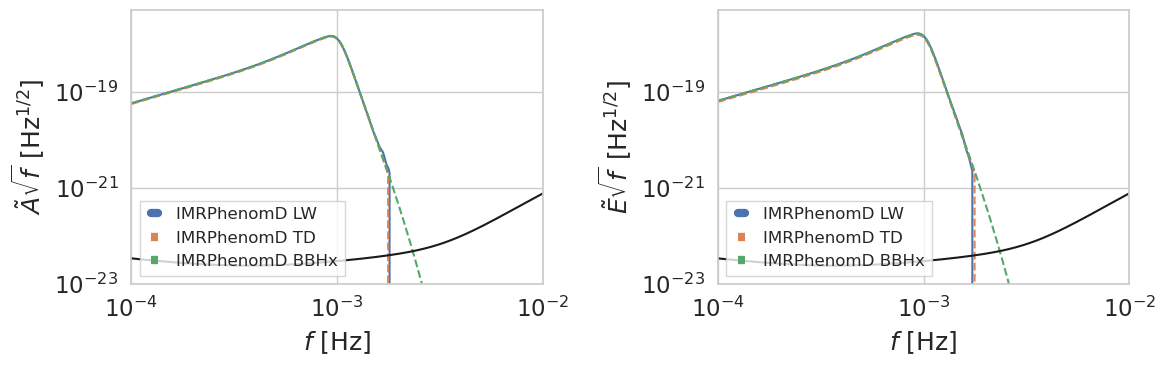

In [50]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD LW")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_A"]), label = "IMRPhenomD TD", ls = '--')
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_A"]), label = "IMRPhenomD BBHx", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD LW")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_td["LISA_E"]), label = "IMRPhenomD TD", ls = '--')
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_bbhx["LISA_E"]), label = "IMRPhenomD BBHx", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [51]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [52]:
data = DataResidualArray([dict_lw["LISA_A"], dict_lw["LISA_E"]], f_arr=frequency_array)

In [53]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [54]:
analysis = AnalysisContainer(data, sens_mat)

In [55]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

4.86733602311773e-06


In [58]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_lw["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

4.790658208464471e-06


In [57]:
psd = get_sensitivity(frequency_array, sens_fn="A1TDISens", return_type="PSD")
print(
    1- match(
        FrequencySeries(dict_td["LISA_A"], deltaF),
        FrequencySeries(dict_bbhx["LISA_A"], deltaF),
        psd=FrequencySeries(psd, deltaF),
        subsample_interpolation=True,
    )[0]
)

2.8517257266713614e-07


In [17]:
dict_seob = lisa_binary_black_hole_LW(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

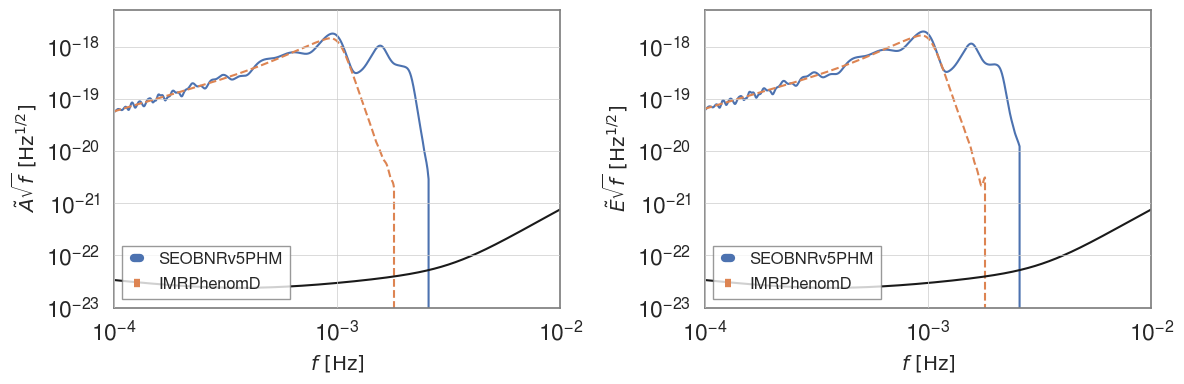

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOBNRv5PHM")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_A"]), label = "IMRPhenomD", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOBNRv5PHM")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_lw["LISA_E"]), label = "IMRPhenomD", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 5e-18)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=3, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [12]:
domega220 = 0.4
dtau220 = 0.4

domega330 = 0
dtau330 = 0
domega210 = 0
dtau210 = 0
domega440 = 0
dtau440 = 0
domega550 = 0
dtau550 = 0
domega320 = 0
dtau320 = 0
domega430 = 0
dtau430 = 0
dA22 = 0
dw22 = 0
dA33 = 0
dw33 = 0
dA21 = 0
dw21 = 0
dA44 = 0
dw44 = 0
dA55 = 0
dw55 = 0
dA32 = 0
dw32 = 0
dA43 = 0
dw43 = 0
dTpeak = 0
da6 = 0
ddSO = 0

In [13]:
dict_pseob = lisa_LW_gwsignal_binary_black_hole_pSEOB(frequency_array, m1, m2, distance, 
                                       a_1, tilt_1, phi_12, a_2, tilt_2, phi_jl, theta_jn, phiRef, 
                                       ra, dec, psi, geocent_time, 
                                       domega220, dtau220, domega330, dtau330, domega210, dtau210, 
                                       domega440, dtau440, domega550, dtau550, domega320, dtau320, 
                                       domega430, dtau430, dA22, dw22, dA33, dw33, dA21, dw21, dA44, 
                                       dw44, dA55, dw55, dA32, dw32, dA43, dw43, dTpeak, da6, ddSO,
                                       waveform_approximant = "SEOBNRv5PHM", 
                                       reference_frequency=f_ref, minimum_frequency=f_min,
                                       # mode_array=[(2,2)]
                                       )

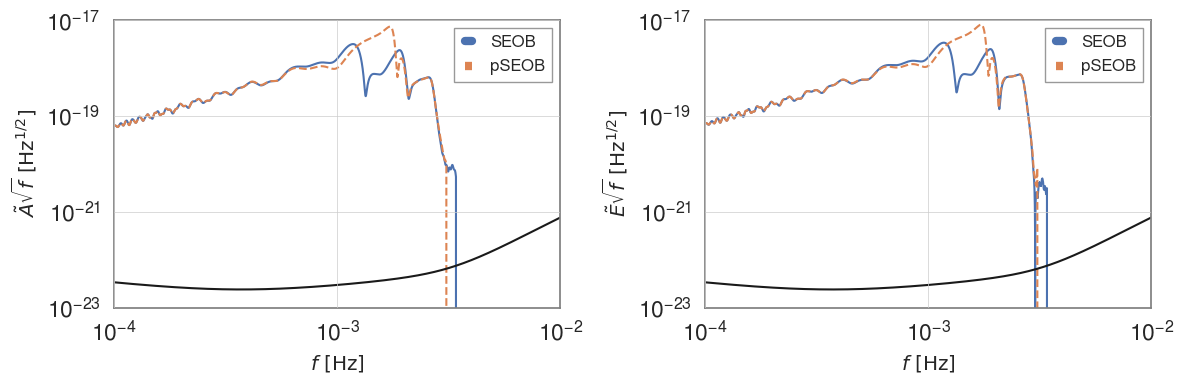

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,4))

ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_A"]), label = "SEOB")
ax1.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_A"]), label = "pSEOB", ls = '--')

ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_seob["LISA_E"]), label = "SEOB")
ax2.loglog(frequency_array, np.sqrt(frequency_array) * np.abs(dict_pseob["LISA_E"]), label = "pSEOB", ls = '--')

fn = np.logspace(-5, -1, 10000)

Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
ax1.loglog(fn, Sn_char_strain, c="k")

Sn_char_strain = get_sensitivity(fn, sens_fn="E1TDISens", return_type="char_strain")
ax2.loglog(fn, Sn_char_strain, c="k")

for ax in (ax1,ax2):
    ax.set_xlim(f_min, f_max)
    ax.set_ylim(1e-23, 1e-17)
    ax.set_xlabel(r"$f~[\rm{Hz}]$")
    ax.legend(loc=1, fontsize=12)

ax1.set_ylabel(r"$\tilde{A}\sqrt{f}~[\rm{Hz}^{1/2}]$")
ax2.set_ylabel(r"$\tilde{E}\sqrt{f}~[\rm{Hz}^{1/2}]$")

plt.tight_layout()


In [15]:
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens 
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

In [16]:
data = DataResidualArray([dict_pseob["LISA_A"], dict_pseob["LISA_E"]], f_arr=frequency_array)

In [17]:
sens_mat = SensitivityMatrix(data.f_arr, [A1TDISens, E1TDISens])

In [18]:
analysis = AnalysisContainer(data, sens_mat)

In [19]:
analysis.snr()

10804.082005243925

In [20]:
template = DataResidualArray([dict_seob["LISA_A"], dict_seob["LISA_E"]], f_arr=frequency_array)

In [21]:
analysis.template_snr(template)

(5663.2155732358015, 0.0005499990976331309)